In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

# matplotlib.use("Agg")

from ase import build
from ase.optimize import FIRE
from ase.io import read
from agox.databases import Database
from agox.environments import Environment
from agox.utils.graph_sorting import Analysis

import numpy as np
from sklearn.decomposition import PCA

/home/ntt203/.conda/envs/raffle_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-02-12 16:04:15,986	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
## Set up the plotting environment
# matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rc('text', usetex=True)
plt.rc('font', family='cmr10', size=12)
plt.rcParams["axes.formatter.use_mathtext"] = True

In [3]:
## Set the plotting parameters
seed = 0
identifier1 = "2"
identifier2 = "3"
# min_energy = -3.6635127# -3.7717605425

In [4]:
## Set the descriptors
from agox.models.descriptors import SOAP, Voronoi
local_descriptor = local_descriptor = SOAP.from_species(["Si", "Ge"], r_cut=5.0)

graph_descriptor = Voronoi(
    covalent_bond_scale_factor=1.3, n_points=8, angle_from_central_atom=20, environment=None
)

In [5]:
## Set the calculators
from chgnet.model import CHGNetCalculator
from ase.calculators.singlepoint import SinglePointCalculator
calc = CHGNetCalculator()

CHGNet v0.3.0 initialized with 412,525 parameters
CHGNet will run on cuda


In [6]:
## Load the unrelaxed structures
unrlxd_structures1 = read("DTMP"+identifier1+"/unrlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in unrlxd_structures1:
  structure.calc = calc

## Load the additional relaxed structures
unrlxd_structures2 = read("DTMP"+identifier2+"/unrlxd_structures_seed"+str(seed)+".traj", index=":")


In [7]:
## Load the relaxed structures
rlxd_structures1 = read("DTMP"+identifier1+"/rlxd_structures_seed"+str(seed)+".traj", index=":")
for structure in rlxd_structures1:
  structure.calc = calc

## Load the additional relaxed structures
rlxd_structures2 = read("DTMP"+identifier2+"/rlxd_structures_seed"+str(seed)+".traj", index=":")

In [8]:
## Read energies from energies_unrlxd_seed0.txt and add to the respective structures using a SinglePointCalculator
## The file has the form "index energy"
## This is done because there seem to be issues with storing the energy in the ASE trajectory file for some setups
filename = "DTMP"+identifier1+"/energies_unrlxd_seed"+str(seed)+".txt"
with open(filename) as f:
    for line in f:
        index, energy = line.split()
        index = int(index)
        energy = float(energy)
        unrlxd_structures1[index].calc = SinglePointCalculator(unrlxd_structures1[index], energy=energy * len(unrlxd_structures1[index]))


filename = "DTMP"+identifier1+"/energies_rlxd_seed"+str(seed)+".txt"
with open(filename) as f:
    for line in f:
        index, energy = line.split()
        index = int(index)
        energy = float(energy)
        rlxd_structures1[index].calc = SinglePointCalculator(rlxd_structures1[index], energy=energy * len(rlxd_structures1[index]))

filename = "DTMP"+identifier2+"/energies_unrlxd_seed"+str(seed)+".txt"
with open(filename) as f:
    for line in f:
        index, energy = line.split()
        index = int(index)
        energy = float(energy)
        unrlxd_structures2[index].calc = SinglePointCalculator(unrlxd_structures2[index], energy=energy * len(unrlxd_structures2[index]))


filename = "DTMP"+identifier2+"/energies_rlxd_seed"+str(seed)+".txt"
with open(filename) as f:
    for line in f:
        index, energy = line.split()
        index = int(index)
        energy = float(energy)
        rlxd_structures2[index].calc = SinglePointCalculator(rlxd_structures2[index], energy=energy * len(rlxd_structures2[index]))

In [9]:
unrlxd_structures = unrlxd_structures1 + unrlxd_structures2
rlxd_structures = rlxd_structures1 + rlxd_structures2

In [10]:
## Get bulk reference energies
Si_bulk = build.bulk("Si", crystalstructure="diamond", a=5.43)
Si_bulk.calc = calc
Si_reference_energy = Si_bulk.get_potential_energy() / len(Si_bulk)
Si_cubic = build.make_supercell(Si_bulk, [[-1, 1, 1], [1, -1, 1], [1, 1, -1]])

Ge_bulk = build.bulk("Ge", crystalstructure="diamond", a=5.65)
Ge_bulk.calc = calc
Ge_reference_energy = Ge_bulk.get_potential_energy() / len(Ge_bulk)
Ge_cubic = build.make_supercell(Ge_bulk, [[-1, 1, 1], [1, -1, 1], [1, 1, -1]])


In [14]:
## Get slab energetics
Si_slab_vac = read("Si_slab.vasp")
Ge_slab_vac = read("Ge_slab.vasp")
Si_slab_vac.calc = calc
Ge_slab_vac.calc = calc
optimizer = FIRE(Si_slab_vac)
optimizer.run(fmax=0.05, steps=100)
optimizer = FIRE(Ge_slab_vac)
optimizer.run(fmax=0.05, steps=100)

      Step     Time          Energy          fmax
FIRE:    0 16:04:18     -409.767609        0.108492


FIRE:    1 16:04:18     -409.770844        0.094165
FIRE:    2 16:04:18     -409.775543        0.067700
FIRE:    3 16:04:18     -409.779114        0.040970
      Step     Time          Energy          fmax
FIRE:    0 16:04:18     -345.926056        0.255278
FIRE:    1 16:04:18     -345.937775        0.245574
FIRE:    2 16:04:18     -345.959961        0.230152
FIRE:    3 16:04:18     -345.990173        0.200196
FIRE:    4 16:04:18     -346.024353        0.149001
FIRE:    5 16:04:18     -346.059906        0.150141
FIRE:    6 16:04:18     -346.098694        0.165839
FIRE:    7 16:04:18     -346.141357        0.170946
FIRE:    8 16:04:18     -346.193115        0.155802
FIRE:    9 16:04:18     -346.253387        0.119266
FIRE:   10 16:04:18     -346.319122        0.101087
FIRE:   11 16:04:18     -346.387360        0.098366
FIRE:   12 16:04:18     -346.457977        0.077962
FIRE:   13 16:04:18     -346.520935        0.059484
FIRE:   14 16:04:18     -346.565796        0.042936


np.True_

In [15]:
## Get abrupt interface energetics
SiGe_abrupt = read("SiGe_abrupt_interface.vasp")
SiGe_abrupt.calc = calc
SiGe_abrupt.set_cell(rlxd_structures[0].get_cell(), scale_atoms=True)
optimizer = FIRE(SiGe_abrupt)
optimizer.run(fmax=0.05, steps=100)

      Step     Time          Energy          fmax
FIRE:    0 16:04:18     -767.812866        0.584523


FIRE:    1 16:04:18     -767.876892        0.536847
FIRE:    2 16:04:18     -767.992249        0.464280
FIRE:    3 16:04:18     -768.138184        0.352446
FIRE:    4 16:04:18     -768.299500        0.250566
FIRE:    5 16:04:18     -768.467712        0.243211
FIRE:    6 16:04:18     -768.639587        0.254608
FIRE:    7 16:04:18     -768.819458        0.240590
FIRE:    8 16:04:18     -769.025574        0.200278
FIRE:    9 16:04:19     -769.251221        0.200775
FIRE:   10 16:04:19     -769.463135        0.211233
FIRE:   11 16:04:19     -769.657715        0.196229
FIRE:   12 16:04:19     -769.832764        0.177387
FIRE:   13 16:04:19     -769.973877        0.155502
FIRE:   14 16:04:19     -770.089417        0.136751
FIRE:   15 16:04:19     -770.179565        0.091193
FIRE:   16 16:04:19     -770.231079        0.065349
FIRE:   17 16:04:19     -770.248657        0.110161
FIRE:   18 16:04:19     -770.253174        0.094118
FIRE:   19 16:04:19     -770.259644        0.059759
FIRE:   20 1

np.True_

In [16]:
## Get abrupt interface area
area = np.linalg.norm(np.cross(SiGe_abrupt.get_cell()[0], SiGe_abrupt.get_cell()[1]))
print("Interface area: ", area)

Interface area:  122.76639830932618


In [17]:
## Function to get the interface formation energy
def get_interface_energy(struc, Si_slab, Ge_slab, extra=False):
    energy = struc.get_potential_energy()
    cell = struc.get_cell()
    area = np.linalg.norm(np.cross(cell[0], cell[1]))
    Si_energy = Si_slab.get_potential_energy()
    Ge_energy = Ge_slab.get_potential_energy()
    ## need to subtract remaining silicon and germanium energies also
    if extra:
        return (energy - Si_energy - Ge_energy - 16*(Si_reference_energy + Ge_reference_energy)) / (2.0 * area)
    else:
        return (energy - Si_energy - Ge_energy) / (2.0 * area)

In [18]:
# print("abrupt match 2 layers energy: ", get_interface_energy(abrupt, Si_slab, Ge_slab))
# print("abrupt match 3 layers energy: ", get_interface_energy(abrupt_3, Si_slab_3, Ge_slab_3))

In [19]:
abrupt_en_per_area = get_interface_energy(SiGe_abrupt, Si_slab_vac, Ge_slab_vac, False)
print("Abrupt min energy: ", abrupt_en_per_area)

Abrupt min energy:  -0.05668986042757322


In [20]:
## Calculate energies per atom for each unrelaxed structure
unrlxd_en_per_area = [get_interface_energy(structure, Si_slab_vac, Ge_slab_vac, False) for structure in unrlxd_structures]
print("Unrelaxed min energy: ", np.min(unrlxd_en_per_area))

Unrelaxed min energy:  0.04692765280528694


In [21]:
## Calculate energies per atom for each relaxed structure
rlxd_en_per_area = [get_interface_energy(structure, Si_slab_vac, Ge_slab_vac, False) for structure in rlxd_structures]
print("Relaxed min energy: ", np.min(rlxd_en_per_area))

Relaxed min energy:  -0.06195819362704165


In [22]:
## Set up the PCA
pca = PCA(n_components=2)

In [23]:
## Get the 'super atom' descriptors for the unrelaxed structures
unrlxd_super_atoms = []
for structure in unrlxd_structures:
  unrlxd_super_atoms.append( np.mean(local_descriptor.get_features(structure), axis=0) )

In [24]:
## Get the 'super atom' descriptors for the relaxed structures
rlxd_super_atoms = []
for structure in rlxd_structures:
  rlxd_super_atoms.append( np.mean(local_descriptor.get_features(structure), axis=0) )

In [25]:
## Fit the PCA model to the unrelaxed or relaxed structures
rlxd_string = "rlxd"

In [26]:
## Save pca model
import pickle
if True:
  pca.fit(np.squeeze([arr for arr in rlxd_super_atoms]))
  with open("pca_model_all_rlxd_"+str(seed)+".pkl", "wb") as f:
    pickle.dump(pca, f)

## Load pca model
with open("pca_model_all_"+rlxd_string+"_0.pkl", "rb") as f:
  pca = pickle.load(f)

In [27]:
abrupt_super_atom = []
abrupt_super_atom.append(np.mean(local_descriptor.get_features(SiGe_abrupt), axis=0))
abrupt_super_atom.append(np.mean(local_descriptor.get_features(SiGe_abrupt), axis=0))

In [28]:
## Transform the unrelaxed and relaxed structures to the reduced space
unrlxd_X_reduced = pca.transform(np.squeeze([arr for arr in unrlxd_super_atoms]))
rlxd_X_reduced = pca.transform(np.squeeze([arr for arr in rlxd_super_atoms]))
abrupt_X_reduced = pca.transform(np.squeeze([arr for arr in abrupt_super_atom]))

In [29]:
## Get the index of the structure with the minimum energy
min_energy_index = np.argmin(rlxd_en_per_area)
print(min_energy_index)

147


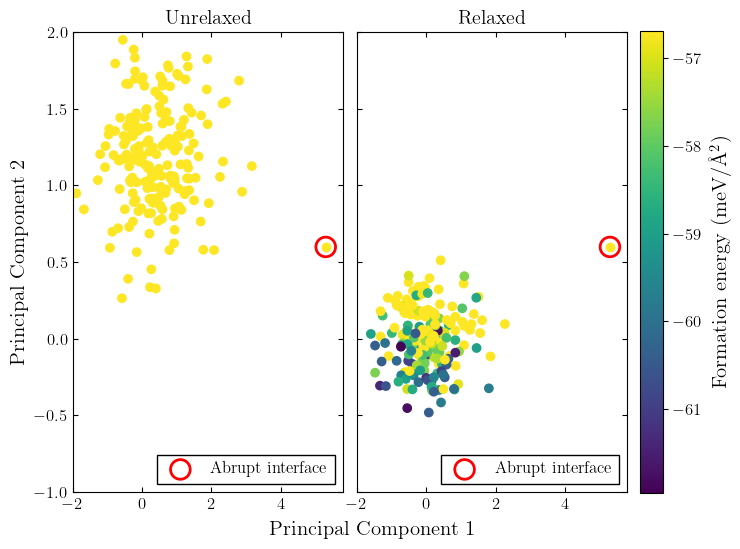

In [30]:
## Plot the PCA
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

plt.subplots_adjust(wspace=0.05, hspace=0)

## Get the maximum energy for the colourbar
scaled_unrlxd_ens = [x * 1000 for x in unrlxd_en_per_area]
scaled_rlxd_ens = [x * 1000 for x in rlxd_en_per_area]
scaled_abrupt_en = abrupt_en_per_area * 1000
min_en = max(-0.08*1000, min(np.max(scaled_unrlxd_ens), np.min(scaled_rlxd_ens)))
max_en = min(max(np.max(scaled_unrlxd_ens), np.max(scaled_rlxd_ens)), scaled_abrupt_en)

## Plot the PCA
axes[0].scatter(unrlxd_X_reduced[:, 0], unrlxd_X_reduced[:, 1], c=scaled_unrlxd_ens, cmap="viridis", vmin = min_en, vmax = max_en)
axes[1].scatter(rlxd_X_reduced[:, 0], rlxd_X_reduced[:, 1], c=scaled_rlxd_ens, cmap="viridis", vmin = min_en, vmax = max_en)

## Add the minimum energy structures to the plot
for ax in axes:
  ax.scatter(abrupt_X_reduced[0, 0], abrupt_X_reduced[0, 1], s=200, edgecolor='red', facecolor='none', linewidth=2, label="Abrupt interface")
  ax.scatter(abrupt_X_reduced[0, 0], abrupt_X_reduced[0, 1], c=abrupt_en_per_area, cmap="viridis", vmin = min_en, vmax = max_en)
  ax.legend(fontsize=10)
  handles, labels = ax.get_legend_handles_labels()
  ax.legend(handles[::-1], labels[::-1], facecolor='white', framealpha=1.0, edgecolor='black', fancybox=False, loc='lower right')

## Add labels
fig.text(0.5, 0.04, 'Principal Component 1', ha='center', fontsize=15)
axes[0].set_ylabel('Principal Component 2', fontsize=15)
axes[0].set_title('Unrelaxed')
axes[1].set_title('Relaxed')
if rlxd_string == "rlxd":
  xlims = [-2, 5.8]
  ylims = [-1, 2]
else:
  xlims = [-42, 55]
  ylims = [-12, 30]

for ax in axes:
  ax.tick_params(axis='both', direction='in')
  ax.set_xlim(xlims)
  ax.set_ylim(ylims)

## Unify tick labels
xticks = axes[0].get_xticks()
xticks = xticks[(xticks >= xlims[0]) & (xticks <= xlims[1])]

axes[1].set_xticks(xticks)
axes[1].set_yticklabels([])
axes[0].tick_params(axis='x', labelbottom=True, top=True)
axes[1].tick_params(axis='x', labelbottom=True, top=True)
axes[0].tick_params(axis='y', labelbottom=True, right=True)
axes[1].tick_params(axis='y', labelbottom=True, right=True)

## Make axes[0] and axes[1] the same width
axes[0].set_box_aspect(1.7)
axes[1].set_box_aspect(1.7)

## Add colorbar next to the axes
cbar = fig.colorbar(axes[1].collections[0], ax=axes, orientation='vertical', fraction=0.085, pad=0.02)
cbar.set_label('Formation energy (meV/Å$^2$)', fontsize=15)

## Save the figure
plt.savefig('Si-Ge_RAFFLE'+identifier1+'_pca_'+rlxd_string+'_fit_seed'+str(seed)+'.pdf', bbox_inches='tight', pad_inches=0, facecolor=fig.get_facecolor(), edgecolor='none')